In [ ]:
# dataset: https://www.kaggle.com/datasets/msambare/fer2013
# to run this command, sign in https://www.kaggle.com and upload upload
# your kaggle.json to ~/.kaggle

! kaggle datasets download -d msambare/fer2013

In [ ]:
! unzip fer2013.zip -d dataset

In [3]:
! rm fer2013.zip

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import os


train_dir = 'dataset/train/'
test_dir = 'dataset/test/'

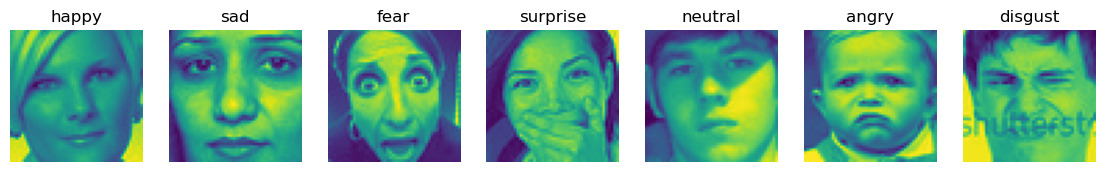

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    plt.subplot(1,7,i)
    plt.imshow(matplotlib.image.imread((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1])))
    # img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [15]:
import matplotlib.pyplot as plt

import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import ToTensor

import os

from tqdm.auto import tqdm

from PIL import Image

In [16]:
print('Pytorch CUDA Version is ', torch.version.cuda)
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'Cuda device count: {torch.cuda.device_count()}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Pytorch CUDA Version is  None
Cuda is available: False
Cuda device count: 0
Using device: cpu


In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        

        self.images_files = []
        self.labels = []

        self.mapping = {
            'angry': 0,
            'disgust': 1,
            'fear': 2,
            'happy': 3,
            'neutral': 4,
            'sad': 5,
            'surprise': 6
        }

        for expression in os.listdir(img_dir):
            prefix = img_dir + '/' + expression + '/'
            list_emotion = os.listdir(prefix)
            for i in range(len(list_emotion)):
                list_emotion[i] = prefix + list_emotion[i]
            self.images_files.extend(list_emotion)
            self.labels.extend([self.mapping[expression]] * len(list_emotion))

    def __len__(self):
        return len(self.images_files)

    def __getitem__(self, idx):
        img_path = self.images_files[idx]
        image = ToTensor()(Image.open(img_path))
        image = T.Resize((224, 224))(image)

        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [18]:
reverse_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

In [19]:
emotions_train = CustomImageDataset('dataset/train')
emotions_test = CustomImageDataset('dataset/test')

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_dataloader = DataLoader(emotions_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(emotions_test, batch_size=64, shuffle=True)

In [21]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

dataset_sizes = {
    'train': len(emotions_train),
    'val': len(emotions_test)
}

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'val':
                scheduler.step(running_loss)
                print(scheduler._last_lr)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# for model class definition

model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

In [24]:
# do not execute this! for loading the model, see below

num_ftrs = model_ft.fc.in_features
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)


exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=2)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 1.2486 Acc: 0.5287


  0%|          | 0/113 [00:00<?, ?it/s]

[0.001]
val Loss: 1.2655 Acc: 0.5418

Epoch 1/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 1.0319 Acc: 0.6122


  0%|          | 0/113 [00:00<?, ?it/s]

[0.001]
val Loss: 1.1259 Acc: 0.5868

Epoch 2/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.9165 Acc: 0.6540


  0%|          | 0/113 [00:00<?, ?it/s]

[0.001]
val Loss: 1.0473 Acc: 0.6098

Epoch 3/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.8005 Acc: 0.7026


  0%|          | 0/113 [00:00<?, ?it/s]

[0.001]
val Loss: 1.0294 Acc: 0.6346

Epoch 4/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.6616 Acc: 0.7540


  0%|          | 0/113 [00:00<?, ?it/s]

[0.001]
val Loss: 1.1214 Acc: 0.6116

Epoch 5/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.4926 Acc: 0.8206


  0%|          | 0/113 [00:00<?, ?it/s]

[0.001]
val Loss: 1.2072 Acc: 0.6198

Epoch 6/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.3231 Acc: 0.8870


  0%|          | 0/113 [00:00<?, ?it/s]

[0.0001]
val Loss: 1.3482 Acc: 0.6236

Epoch 7/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.1020 Acc: 0.9719


  0%|          | 0/113 [00:00<?, ?it/s]

[0.0001]
val Loss: 1.4284 Acc: 0.6616

Epoch 8/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.0345 Acc: 0.9932


  0%|          | 0/113 [00:00<?, ?it/s]

[0.0001]
val Loss: 1.5663 Acc: 0.6580

Epoch 9/9
----------


  0%|          | 0/449 [00:00<?, ?it/s]

train Loss: 0.0203 Acc: 0.9963


  0%|          | 0/113 [00:00<?, ?it/s]

[1e-05]
val Loss: 1.6536 Acc: 0.6577

Training complete in 213m 43s
Best val Acc: 0.661605


In [25]:
#!g1.1

torch.save(model_ft, "checkpoint.pt")

torch.Size([64, 1, 224, 224])


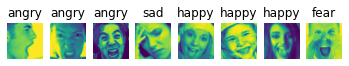

In [26]:
# showcase of model results

model_ft.eval()
j = 1
for inputs, labels in dataloaders['train']:
    # shape = (batch_size, num_channels, height, width)
    print(inputs.shape)
    out = model_ft(inputs)
    for i, image in enumerate(inputs[:8]):
        plt.subplot(1,8,j)
        plt.imshow(image.permute(1, 2, 0))
        # img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
        plt.title(reverse_mapping[int(labels[i])])
        plt.axis('off')
        j += 1
    break
    

Current shape: torch.Size([1, 224, 224])
Correct shape: torch.Size([1, 1, 224, 224])
Model predicted:  angry


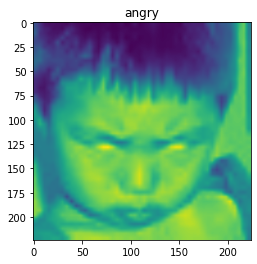

In [27]:
# how to evaluate other images

# image of a happy face
img, label = emotions_train[0]
# right now the size is not correct, see above what the model expects
print('Current shape:', img.shape)
plt.imshow(img.permute(1, 2, 0))
plt.title(f'{reverse_mapping[label]}')

# model evaluation
model_ft = torch.load('checkpoint.pt')
model_ft.eval()
# img should be a tensor
out = model_ft(img.clone().unsqueeze_(0))
print('Correct shape:', img.clone().unsqueeze_(0).shape)
# preds is a tensor with all labels
_, preds = torch.max(out, 1)
print('Model predicted: ', reverse_mapping[int(preds)])


In [ ]:
import torch

In [ ]:
emotions_train = CustomImageDataset('dataset/train')
emotions_test = CustomImageDataset('dataset/test')
img, label = emotions_train[0]

In [ ]:
model = torch.load('checkpoint.pt')
example = img.clone().unsqueeze_(0)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save('model.pt')